# Conic Non-linear optimization

Description todo

Basic idea: in part (1) we discussed how to use callbacks to solve IPs.
In part (2) we will cover how to solve NLPs
In part (3) we will combine parts (1)-(2) to do something cool.

Credit: some of this material is adapted from the 2016 version of this course, written by Miles Lubin and Yeesian Ng. 

Some of this material is also adapted from the Boyd and Vandenberghe convex optimization book, specifically chapter 8.

# Part 2(a): SVM's
Support Vector Machines are a popular model in machine learning for classification. We'll use this example to illustrate the basic use of JuMP.jl for solving nontrivial conic optimization problems.

Specifically, we are going to build our own custom svm solver, so that we can constraints which off-the-shelf SVM solvers can't handle.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now let's write our own SVM solver!

In [97]:
#Pkg.add("PyPlot")
using Mosek #, Pick your favourite solver here e.g. CPLEX/Gurobi. Note that you need to install Mosek to use it
using Distributions
using PyPlot
using LinearAlgebra

In [8]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-3.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

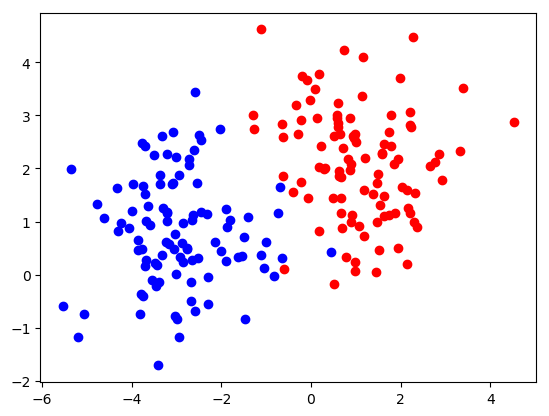

In [9]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into JuMP form.

In [28]:
using JuMP
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    svmModel=Model(solver=MosekSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)


    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm (generic function with 1 method)

In [29]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : QO (quadratic optimization problem)
  Constraints            : 1000            
  Cones                  : 0               
  Scalar variables       : 1003            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Quadratic to conic reformulation started.
Quadratic to conic reformulation terminated. Time: 0.00    
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   

([2.16569, 0.641245], -1.1451882689005672)

And the solution?

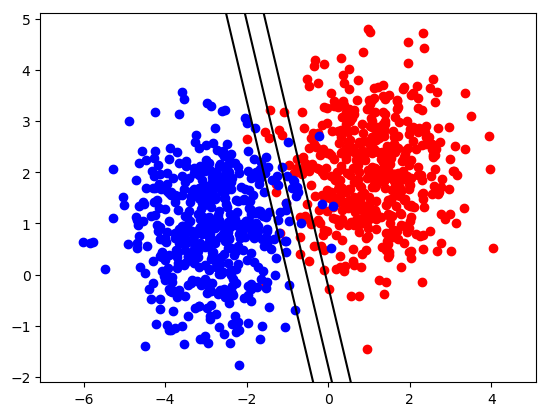

In [30]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Exercise: how would you cross-validate $\gamma$?
Also discuss what changes you would make, to make your code scale.

Bonus exercise: if we were instead interested in hard-margin SVM, how could we generate the seperating hyperplane by solving one LP and looking at its dual?

# Part 2(b): Non-linear discrimination via Semidefinite Optimization

This part of the notebook is adpated from Matlab code written by Lieven Vandenberghe and Stephen Boyd

A classic semidefinite optimization problem is as follows:

Given a set of data points of one class $\{x_i\}_{i=1}^n$ and of a second class $\{y_j\}_{j=1}^m$, generate a quadratic function $f(\cdot): \mathbb{R}^n \mapsto \mathbb{R}$ such that $f(x_i)<0 \ \forall i$ and $f(y_j))>0, \forall j$. That is, seek $P, q, r$ such that $f(x)=x^\top Px+q^\top x+r$, with the set of $x$ such that $f(x)=0$ providing the surface of the ellipsoid. The specifics of how this is done are laid out in section $8.6.2$ of the Boyd and Vandenberghe convex optimization book. In this class, we will skip ahead to the final formulation. 

It turns out that solving this problem is equivalent to solving the following semidefinite feasibility problem:

\begin{align*}
\min_{P, q, r} \quad & 0\\
\text{s.t.} \quad & x_i^\top P x_i+q^\top x_i+r \geq 1, \forall i,\\
& y_j^\top P y_j+q^\top y_j+r \leq -1, \forall j,\\
& P \preceq -\mathbb{I},
\end{align*}
where the last constraint can be interpreted as "P is a symmetric matrix with all eigenvalues at most $-1$".
            

We will study this problem in a 2d setting, so that we can easily plot it.

In [172]:
# Function to generate some random test data
function gen_data2(N, M)
    n=2 #dimensionality of the data
    
    x=randn(2, N)
    y=randn(2,M)

    x = x*LinearAlgebra.diagm(vec(0.5*rand(1,N)./sqrt(sum(x.^2))));
    y = y*LinearAlgebra.diagm(vec((2+rand(1,N))./sqrt(sum(y.^2))));
    T = [1 -1; 2 1];  

    x = T*x;  y = T*y;
    
    return x,y
end

gen_data2 (generic function with 1 method)

In [242]:
srand(1234) #Needed some tuning to ensure that the problem is feasible
dims=40
x,y=gen_data2(dims,dims)

Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
┌ Warning: `srand` is deprecated, use `Random.seed!` instead.
│   caller = top-level scope at In[242]:1
└ @ Core In[242]:1


([0.0884207 0.0113754 … 0.0109852 -0.0140279; 0.0416316 -0.0526907 … -0.144886 0.0184765], [-0.309182 -0.334087 … 0.342583 -0.162972; -0.376013 -0.507898 … -1.75049 0.964567])

Let's build a JuMP model to solve this problem

In [243]:
using JuMP
function ellipsoid(x,y)
    p = size(x,1) # problem dimension
    n = size(x,2) # number of points
    m = size(y,2)
    ellipsoidModel=Model(solver=MosekSolver(MSK_DPAR_INTPNT_CO_TOL_PFEAS=1e-4)) #Change to the solver you are using
    @variable(ellipsoidModel, P[1:p, 1:p])
    @variable(ellipsoidModel, q[1:p])
    @variable(ellipsoidModel, r)
    @constraint(ellipsoidModel, P.==P')
    
    @SDconstraint(ellipsoidModel, P <=-eye(p))
    @constraint(ellipsoidModel, xi[i=1:n], x[:,i]'*P*x[:,i]+q'*x[:,i]+r>=1.0)
    @constraint(ellipsoidModel, yi[i=1:m], y[:,i]'*P*y[:,i]+q'*y[:,i]+r<=-1.0)
    
    status=solve(ellipsoidModel)
    return getvalue(P), getvalue(q), getvalue(r)
end

ellipsoid (generic function with 1 method)

In [244]:
P, q, r=ellipsoid(x,y)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 88              
  Cones                  : 0               
  Scalar variables       : 7               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

([-1236.02 473.847; 473.847 -515.229], [-78.5504, 22.2506], 28.869450159591214)

# Let's plot the results

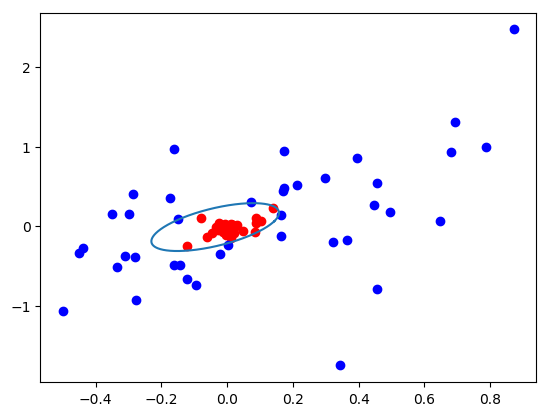

┌ Warning: `sqrtm` is deprecated, use `sqrt` instead.
│   caller = top-level scope at In[245]:6
└ @ Core In[245]:6
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


In [245]:
r = -r; P = -P; q = -q;
c = 0.25*q'*inv(P)*q - r;
xc = -0.5*inv(P)*q;
nopts = 1000;
angles = range(0, stop=2*pi, length=nopts);
ell = (sqrtm(P^(-1)*c))*hcat(cos.(angles), sin.(angles))'+ repmat(xc,1,nopts);
plot(x[1,1:dims], x[2,1:dims], "ro", y[1,1:dims], y[2,1:dims], "bo", ell[1,1:nopts], ell[2, 1:nopts], "-");

# Making the method scale

The above problem is an SDP, which is notoriously difficult to scale. Fortunately, however, because we are operating in a two-dimensional space, the SDP constraint controls the eigenvalues of a 2x2 matrix, which can also be modelled by a (much more tractable!) second order cone constraint. We can implement this idea as follows (c.f. Kim and Kojima, 2003):

If we have the following SDO constraint:
\begin{align*}
\begin{bmatrix}
a_{1,1} & a_{1,2}\\
a_{2,1} & a_{2,2}
\end{bmatrix} \succeq 0_{2 \times 2}
\end{align*}
Then we can equivalently model this via the following SOCP constraint:
\begin{align*}
\vert \vert \begin{bmatrix}
a_{2,1} + a_{1,2}\\
a_{1,1} - a_{2,2} \\
\end{bmatrix}\vert \vert_2 \leq a_{1,1}+a_{2,2}
\end{align*}
Note that this idea doesn't work if $P \in \mathbb{R}^{3 \times 3}$ (why?)

This idea allows us to rewrite our ellipsoid method as follows (note that we are applying the constraint to $-\mathbb{I}-P$, not $P$):

In [246]:
using JuMP
function ellipsoid_socp(x,y)
    p=2
    n = size(x,2) # number of points
    m = size(y,2)
    ellipsoidModel=Model(solver=MosekSolver(MSK_DPAR_INTPNT_CO_TOL_PFEAS=1e-4)) #Change to the solver you are using
    @variable(ellipsoidModel, P[1:p, 1:p])
    @variable(ellipsoidModel, q[1:p])
    @variable(ellipsoidModel, r)
    @constraint(ellipsoidModel, P.==P')
    @constraint(ellipsoidModel, norm([-2.0*P[1,2]; -P[1,1]+P[2,2]])<=-2.0-P[1,1]-P[2,2])
    
    @constraint(ellipsoidModel, xi[i=1:n], x[:,i]'*P*x[:,i]+q'*x[:,i]+r>=1.0)
    @constraint(ellipsoidModel, yi[i=1:m], y[:,i]'*P*y[:,i]+q'*y[:,i]+r<=-1.0)
    
    status=solve(ellipsoidModel)
    return getvalue(P), getvalue(q), getvalue(r)
end

ellipsoid_socp (generic function with 1 method)

In [247]:
P, q, r=ellipsoid_socp(x,y)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 87              
  Cones                  : 1               
  Scalar variables       : 10              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

([-847.407 329.919; 329.919 -316.414], [-43.194, 7.10281], 18.26239643821529)

# Let's plot the results for our original problem

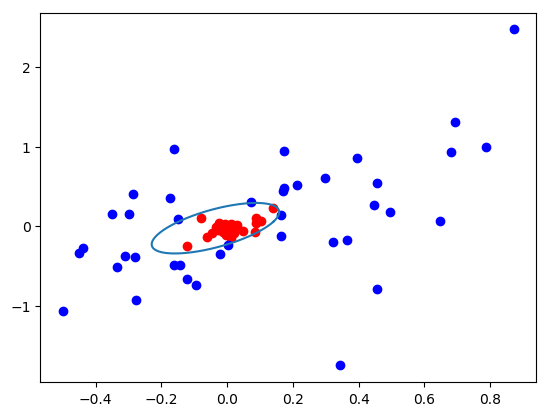

┌ Warning: `sqrtm` is deprecated, use `sqrt` instead.
│   caller = top-level scope at In[249]:6
└ @ Core In[249]:6
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


In [249]:
r = -r; P = -P; q = -q;
c = 0.25*q'*inv(P)*q - r;
xc = -0.5*inv(P)*q;
nopts = 1000;
angles = range(0, stop=2*pi, length=nopts);
ell = (sqrtm(P^(-1)*c))*hcat(cos.(angles), sin.(angles))'+ repmat(xc,1,nopts);
plot(x[1,1:dims], x[2,1:dims], "ro", y[1,1:dims], y[2,1:dims], "bo", ell[1,1:nopts], ell[2, 1:nopts], "-");

# Let's try a larger-scale example

In [264]:
# Function to generate some random test data
function gen_data3(N, M)
    n=2 #dimensionality of the data
    
    x=randn(2, N)
    y=randn(2,M)+10*ones(2,M)

    x = x*LinearAlgebra.diagm(vec(0.5*rand(1,N)./sqrt(sum(x.^2))));
    y = y*LinearAlgebra.diagm(vec((2+rand(1,N))./sqrt(sum(y.^2))));
    T = [10 -10; 20 10];  

    x = T*x;  y = T*y;
    
    return x,y
end

gen_data3 (generic function with 1 method)

Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
┌ Warning: `srand` is deprecated, use `Random.seed!` instead.
│   caller = top-level scope at In[265]:1
└ @ Core In[265]:1
┌ Warning: `diagm(v::AbstractVector)` is deprecated, use `diagm(0 => v)` or `Matrix(Diagonal(v))` instead.
│   caller = gen_data3(::Int64, ::Int64) at In[264]:8
└ @ Main ./In[264]:8


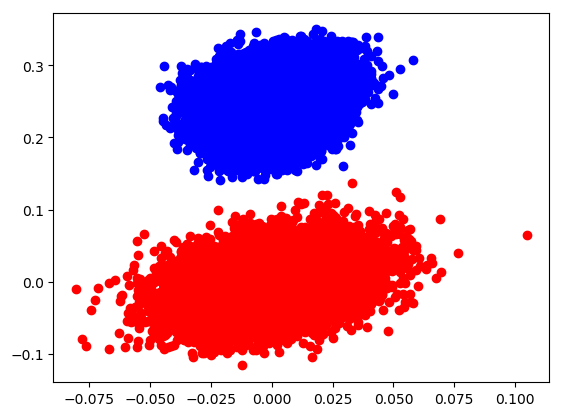

┌ Warning: `a::Number + b::AbstractArray` is deprecated, use `a .+ b` instead.
│   caller = gen_data3(::Int64, ::Int64) at In[264]:9
└ @ Main ./In[264]:9
┌ Warning: `diagm(v::AbstractVector)` is deprecated, use `diagm(0 => v)` or `Matrix(Diagonal(v))` instead.
│   caller = gen_data3(::Int64, ::Int64) at In[264]:9
└ @ Main ./In[264]:9


In [265]:
srand(1234) 
dims=50000
x,y=gen_data3(dims,dims)

In [272]:
P, q, r=ellipsoid(x,y)

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(4176) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6055) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7069) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11346) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(12385) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18096) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18453) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(22560) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(23090) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(23945) of matrix 'A'.
Warning number 705 is d

([-11.2101 13.5355; 13.5355 -36.528], [143.93, -211.834], 26.31057728671778)

In [270]:
P, q, r=ellipsoid_socp(x,y)

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(4176) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6055) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7069) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11346) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(12385) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18096) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18453) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(22560) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(23090) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(23945) of matrix 'A'.
Warning number 705 is d

([-13.2638 26.0904; 26.0904 -61.9419], [53.6149, -78.6685], 11.23285649387165)

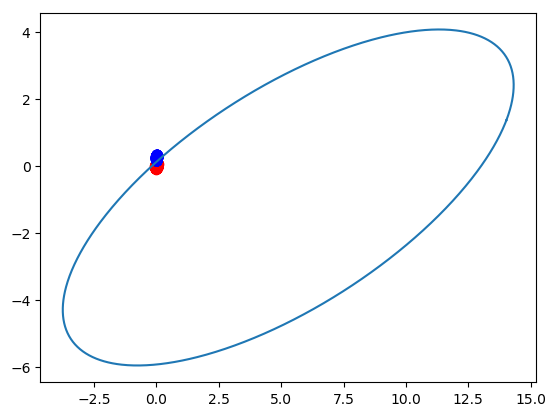

┌ Warning: `sqrtm` is deprecated, use `sqrt` instead.
│   caller = top-level scope at In[273]:7
└ @ Core In[273]:7
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


In [273]:
# Let's plot the final result
r = -r; P = -P; q = -q;
c = 0.25*q'*inv(P)*q - r;
xc = -0.5*inv(P)*q;
nopts = 1000;
angles = range(0, stop=2*pi, length=nopts);
ell = (sqrtm(P^(-1)*c))*hcat(cos.(angles), sin.(angles))'+ repmat(xc,1,nopts);
plot(x[1,1:dims], x[2,1:dims], "ro", y[1,1:dims], y[2,1:dims], "bo", ell[1,1:nopts], ell[2, 1:nopts], "-");

Final comment: if we wanted a "nicer" ellipsoid, we could achieve this by minimizing the volume of the ellipsoid, which corresponds to a log-determinant objective (exercise)